Notebook Color Scheme:


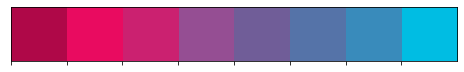

In [4]:
# Libraries
import os
import gc
import wandb
import time
import random
import math
import glob
from scipy import spatial
from tqdm import tqdm
import warnings
import cv2
import pandas as pd
import numpy as np
from numpy import dot, sqrt
import seaborn as sns
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from IPython.display import display_html
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
plt.rcParams.update({'font.size': 16})

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'HandM', '_wandb_kernel': 'aot'}

# Custom colors
class clr:
    S = '\033[1m' + '\033[95m'
    E = '\033[0m'
    
my_colors = ["#AF0848", "#E90B60", "#CB2170", "#954E93", "#705D98", "#5573A8", "#398BBB", "#00BDE3"]
print(clr.S+"Notebook Color Scheme:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

# bk_image = plt.imread("../input/hm-fashion-recommender-dataset/background.jpg")

In [5]:
!wandb login 83f2cd95fe04f4864bd51515cdc0bf7a450d94a3

In [7]:
def insert_image(path, zoom, xybox, ax):
    '''Insert an image within matplotlib'''
    imagebox = OffsetImage(mpimg.imread(path), zoom=zoom)
    ab = AnnotationBbox(imagebox, xy=(0.5, 0.7), frameon=False, pad=1, xybox=xybox)
    ax.add_artist(ab)
    
    
def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


# === 🐝 W&B ===
def save_dataset_artifact(run_name, artifact_name, path):
    '''Saves dataset to W&B Artifactory.
    run_name: name of the experiment
    artifact_name: under what name should the dataset be stored
    path: path to the dataset'''
    
    run = wandb.init(project='HandM', 
                     name=run_name, 
                     config=CONFIG)
    artifact = wandb.Artifact(name=artifact_name, 
                              type='dataset')
    artifact.add_file(path)

    wandb.log_artifact(artifact)
    wandb.finish()
    print("Artifact has been saved successfully.")
    
    
def create_wandb_plot(x_data=None, y_data=None, x_name=None, y_name=None, title=None, log=None, plot="line"):
    '''Create and save lineplot/barplot in W&B Environment.
    x_data & y_data: Pandas Series containing x & y data
    x_name & y_name: strings containing axis names
    title: title of the graph
    log: string containing name of log'''
    
    data = [[label, val] for (label, val) in zip(x_data, y_data)]
    table = wandb.Table(data=data, columns = [x_name, y_name])
    
    if plot == "line":
        wandb.log({log : wandb.plot.line(table, x_name, y_name, title=title)})
    elif plot == "bar":
        wandb.log({log : wandb.plot.bar(table, x_name, y_name, title=title)})
    elif plot == "scatter":
        wandb.log({log : wandb.plot.scatter(table, x_name, y_name, title=title)})
        
        
def create_wandb_hist(x_data=None, x_name=None, title=None, log=None):
    '''Create and save histogram in W&B Environment.
    x_data: Pandas Series containing x values
    x_name: strings containing axis name
    title: title of the graph
    log: string containing name of log'''
    
    data = [[x] for x in x_data]
    table = wandb.Table(data=data, columns=[x_name])
    wandb.log({log : wandb.plot.histogram(table, x_name, title=title)})
    
    
# 🐝 Log Cover Photo
run = wandb.init(project='HandM', name='CoverPhoto', config=CONFIG)
cover = plt.imread("../input/hm-fashion-recommender-dataset/pics/Kaggle Covers.png")
wandb.log({"example": wandb.Image(cover)})
wandb.finish()

In [8]:
%%time

# Read in the data
articles = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv")
customers = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/customers.csv")
transactions = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")
ss = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv")

CPU times: total: 22.6 s
Wall time: 47 s


In [9]:
print(clr.S+"ARTICLES:"+clr.E, articles.shape)
display_html(articles.head(3))
print("\n", clr.S+"CUSTOMERS:"+clr.E, customers.shape)
display_html(customers.head(3))
print("\n", clr.S+"TRANSACTIONS:"+clr.E, transactions.shape)
display_html(transactions.head(3))
print("\n", clr.S+"SAMPLE_SUBMISSION:"+clr.E, ss.shape)
display_html(ss.head(3))

ARTICLES: (105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.



 CUSTOMERS: (1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...



 TRANSACTIONS: (31788324, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2



 SAMPLE_SUBMISSION: (1371980, 2)


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...


In [10]:
# 🐝 W&B Experiment
run = wandb.init(project='HandM', name='Articles', config=CONFIG)

In [11]:
def adjust_id(x):
    '''Adjusts article ID code.'''
    x = str(x)
    if len(x) == 9:
        x = "0"+x
    
    return x

In [12]:
print(clr.S+"There are no missing values in any columns but 'Detail Description':"+clr.E,
        articles.isna().sum()[-1], "total missing values")

# Replace missing values
articles.fillna(value="No Description", inplace=True)

# Adjust the article ID and product code to be string & add "0"
articles["article_id"] = articles["article_id"].apply(lambda x: adjust_id(x))
articles["product_code"] = articles["article_id"].apply(lambda x: x[:3])

There are no missing values in any columns but 'Detail Description': 416 total missing values


In [34]:
# Get all paths from the image folder
all_image_paths = glob.glob(f"../input/h-and-m-personalized-fashion-recommendations/images/*/*")

print(clr.S+"Number of unique article_ids within articles.csv:"+clr.E, len(articles), "\n"+
      clr.S+"Number of unique images within the image folder:"+clr.E, len(all_image_paths), "\n"+
      clr.S+"=> not all article_ids have a corresponding image!!!"+clr.E, "\n")

# 🐝 Log Distinct article IDs
wandb.log({"article_ids":len(articles)})

# Get all valid article ids
# Create a set() - as it moves faster than a list
all_image_ids = set()

for path in tqdm(all_image_paths):
    article_id = path.split('\\')[-1].split('.')[0]
    all_image_ids.add(article_id)

Number of unique article_ids within articles.csv: 105542 
Number of unique images within the image folder: 105100 
=> not all article_ids have a corresponding image!!! 



100%|██████████| 105100/105100 [00:00<00:00, 1449526.66it/s]


In [37]:
# An image path example: ../input/h-and-m-personalized-fashion-recommendations/images/010/0108775015.jpg

# Create full path to the article image
images_path = "../input/h-and-m-personalized-fashion-recommendations/images/"
articles["path"] = images_path + articles["product_code"] + "/" + articles["article_id"] + ".jpg"

# Adjust the incorrect paths and set them to None
for k, article_id in tqdm(enumerate(articles["article_id"])):
    if article_id not in all_image_ids:
        articles.loc[k, "path"] = None

105542it [00:00, 1529535.94it/s]


Total Number of unique Product Names: 45875


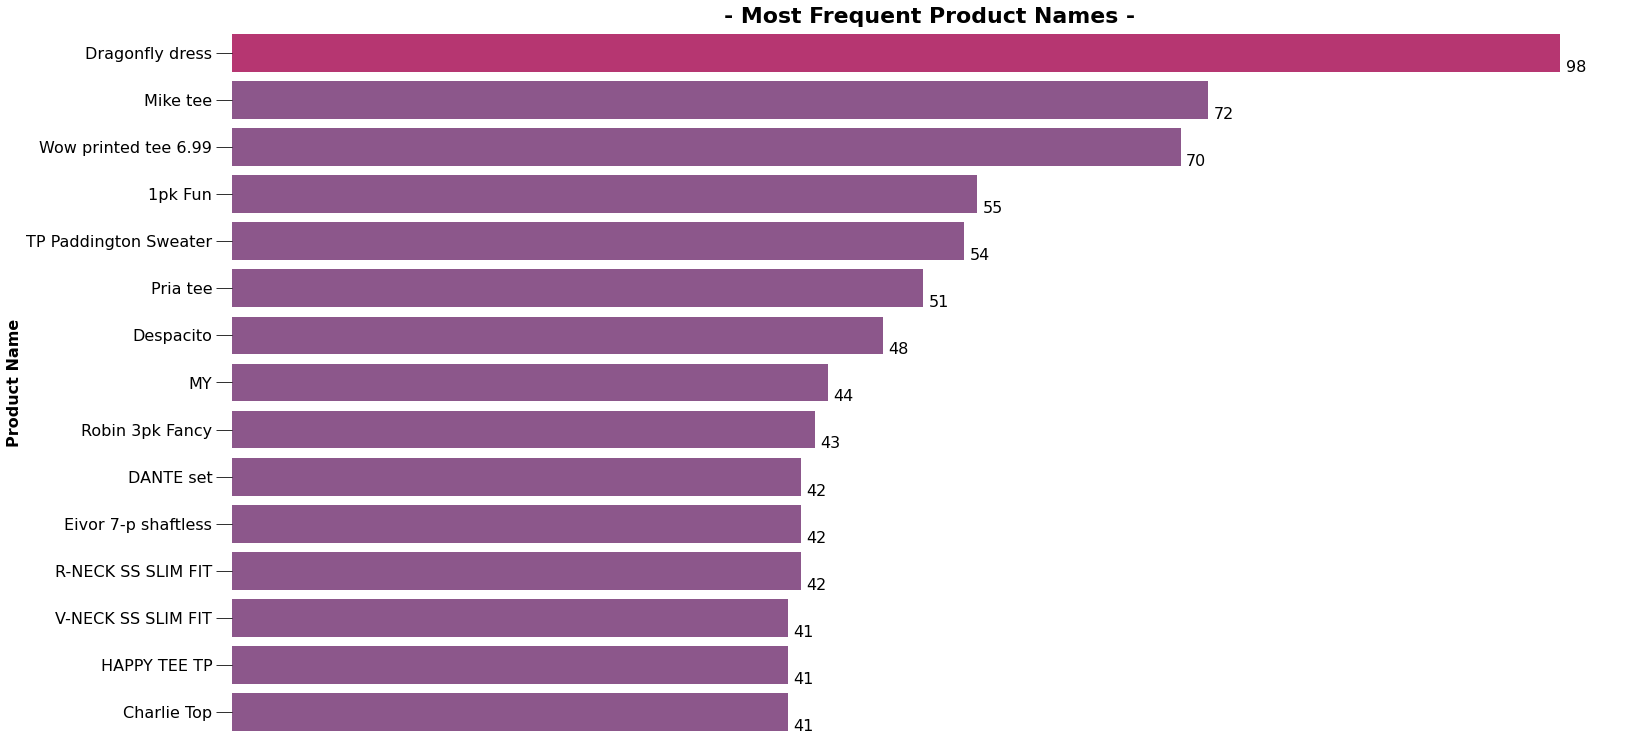

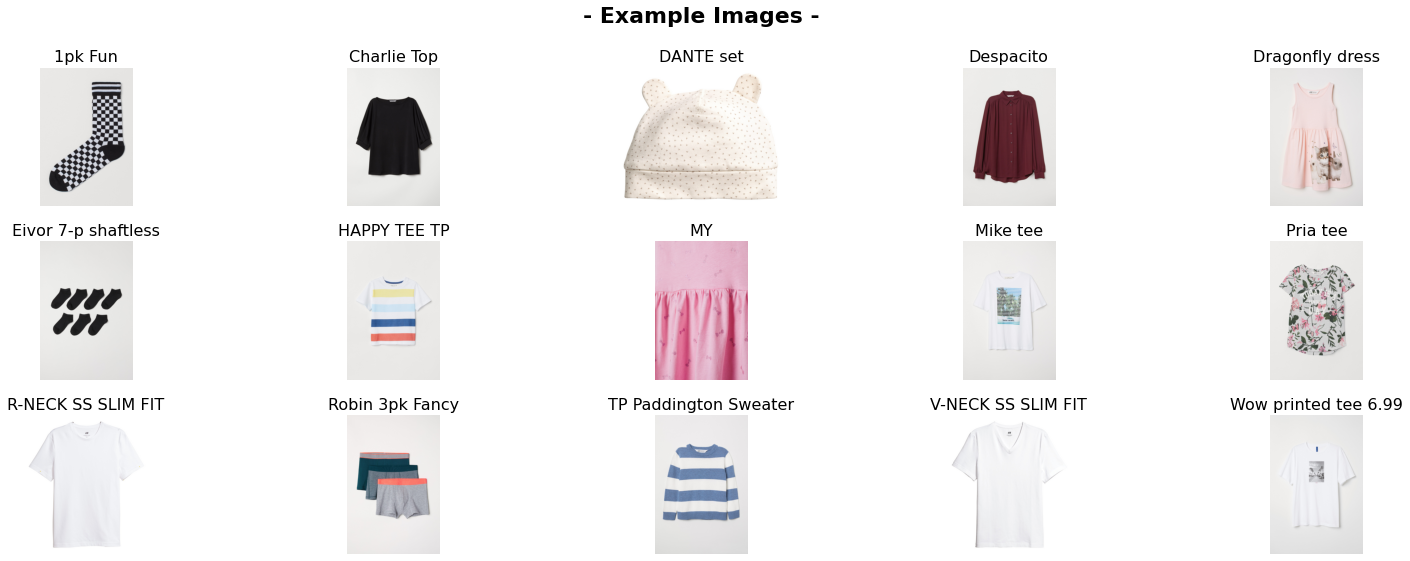

In [39]:
print(clr.S+"Total Number of unique Product Names:"+clr.E, articles["prod_name"].nunique())

# Data
prod_name = articles["prod_name"].value_counts().reset_index().head(15)
total_prod_names = articles["prod_name"].nunique()
clrs = ["#CB2170" if x==max(prod_name["prod_name"]) else '#954E93' for x in prod_name["prod_name"]]

# Get images
prod_name_images = articles[articles["prod_name"].isin(prod_name["index"].tolist())].groupby("prod_name")["path"].first().reset_index()
image_paths = prod_name_images["path"].tolist()
image_names = prod_name_images["prod_name"].tolist()

# Plot
fig, ax = plt.subplots(figsize=(25, 13))
plt.title('- Most Frequent Product Names -', size=22, weight="bold")

sns.barplot(data=prod_name, x="prod_name", y="index", ax=ax,
            palette=clrs)
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
# plt.imshow(bk_image, zorder=0, extent=[x0, x1, y0, y1], alpha=0.35, aspect='auto')

show_values_on_bars(axs=ax, h_v="h", space=0.4)
plt.ylabel("Product Name", size = 16, weight="bold")
plt.xlabel("")
plt.xticks([])
plt.yticks(size=16)
plt.tick_params(size=16)

# insert_image(path='../input/hm-fashion-recommender-dataset/pics/dragonfly.jpg', zoom=0.45, xybox=(92, 11), ax=ax)

sns.despine(left=True, bottom=True)
plt.show();

print("\n")

# Plot
fig, axs = plt.subplots(3, 5, figsize=(23, 8))
fig.suptitle('- Example Images -', size=22, weight="bold")
axs = axs.flatten()

for k, (path, name) in enumerate(zip(image_paths, image_names)):
    axs[k].set_title(f"{name}", size = 16)
    img = plt.imread(path)
    axs[k].imshow(img)
    axs[k].axis("off")

plt.tight_layout()
plt.show()

In [40]:
# 🐝 Log Barplot to W&B
create_wandb_plot(x_data=prod_name["index"], y_data=prod_name["prod_name"],
                  x_name="Product Name", y_name="Frequency", 
                  title="- Most Frequent Product Names -", log="prod_name", plot="bar")